In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from model import GatherProbsLayer, CalculatePrizeProbs, CalculateExpectedPlayers
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})

W0421 02:13:43.425800 139705955919680 deprecation.py:506] From /home/guilherme/anaconda3/envs/cent-patates/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [2]:
model = tf.keras.models.load_model('results/model.h5', custom_objects={
    'GatherProbsLayer': GatherProbsLayer,
    'CalculatePrizeProbs': CalculatePrizeProbs,
    'CalculateExpectedPlayers': CalculateExpectedPlayers
})

normal_probs, lucky_probs = model.get_layer('gather_probs_layer').get_probs()
normal_probs = pd.Series(normal_probs, index=np.arange(1, 50))
lucky_probs = pd.Series(lucky_probs, index=np.arange(1, 11))

W0421 02:13:44.424878 139705955919680 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


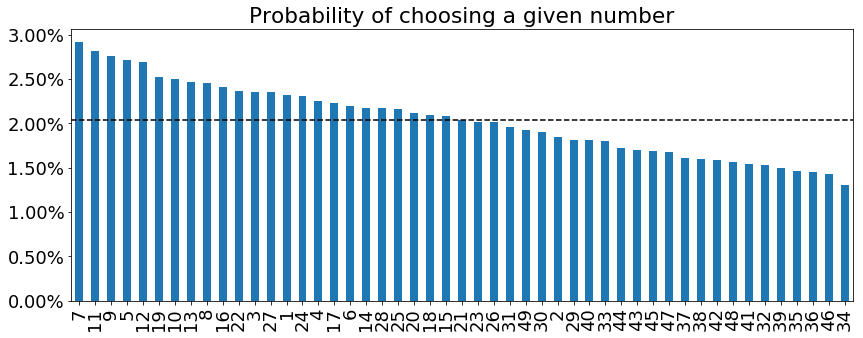

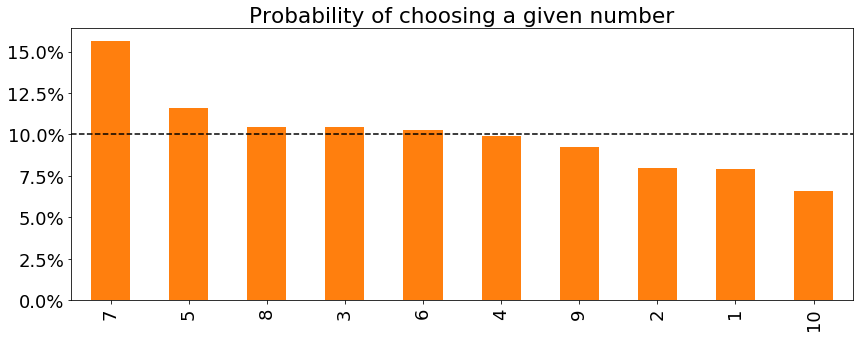

In [3]:
from utils import plot_probs_in_bars, plot_probs_in_grid
plot_probs_in_bars(normal_probs, 'C0')
plt.show()
plot_probs_in_bars(lucky_probs, 'C1')

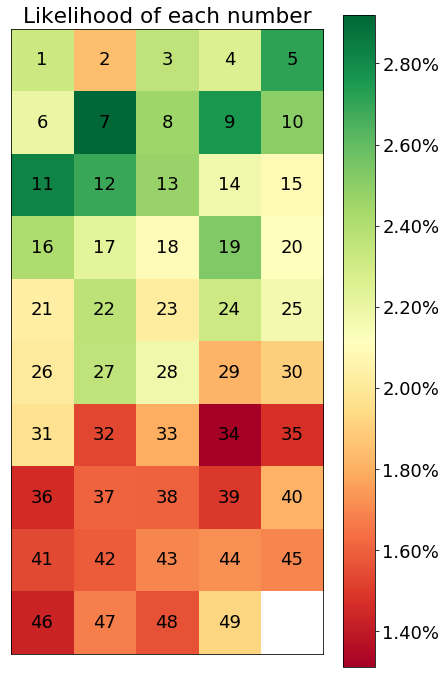

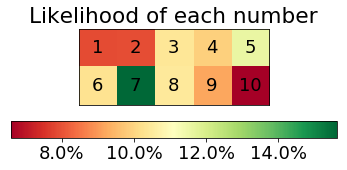

In [4]:
plot_probs_in_grid(normal_probs)
plot_probs_in_grid(lucky_probs)

In [5]:
top_5 = normal_probs.nlargest(5)
bottom_5 = normal_probs.nsmallest(5)
print('Most likely play: ' + str(top_5.index.values) + ' ' + str(lucky_probs.idxmax()))
print('Least likely play: ' + str(bottom_5.index.values) + ' ' + str(lucky_probs.idxmin()))
gap = np.prod(top_5) * lucky_probs.max() / np.prod(bottom_5) / lucky_probs.min()
print(f'People prefer the first one {gap:.1f}x more')

Most likely play: [ 7 11  9  5 12] 7
Least likely play: [34 46 36 35 39] 10
People prefer the first one 65.5x more


In [6]:
data = pd.read_csv('data/data.csv', dayfirst=True, parse_dates=['date'])
inputs_values = [
    data[['ball_1', 'ball_2', 'ball_3', 'ball_4', 'ball_5']].values,
    data[['lucky_ball']].values,
    data[['wins_1_1_and_0_1']].values
]

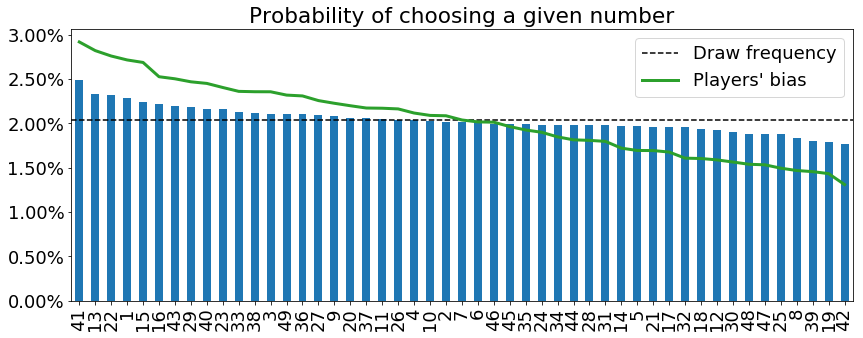

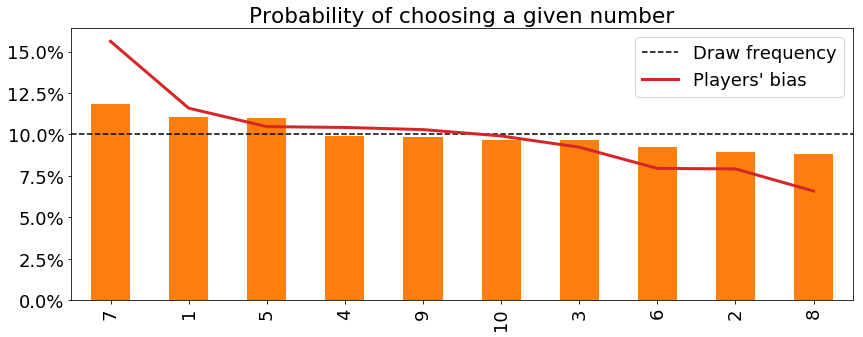

Most frequent draw: [41 13 22  1 15] 7
Least frequent draw: [42 19 39  8 25] 8
First one 4.7x more frequent


In [7]:
from collections import Counter
normal_frequency = Counter({n: 0 for n in range(1, 50)})
lucky_frequency = Counter({n: 0 for n in range(1, 11)})
for i in range(1, 6):
    normal_frequency.update(data[f'ball_{i}'].values)
lucky_frequency.update(data['lucky_ball'].values)
normal_frequency = pd.Series(normal_frequency)
normal_frequency /= normal_frequency.sum()
lucky_frequency = pd.Series(lucky_frequency)
lucky_frequency /= lucky_frequency.sum()

plot_probs_in_bars(normal_frequency, 'C0')
plt.plot(range(0, 49), normal_probs.sort_values(ascending=False).values, linewidth=3, color='C2')
plt.legend(['Draw frequency', 'Players\' bias'])
plt.show()

plot_probs_in_bars(lucky_frequency, 'C1')
plt.plot(range(0, 10), lucky_probs.sort_values(ascending=False).values, linewidth=3, color='C3')
plt.legend(['Draw frequency', 'Players\' bias'])
plt.show()

top_5 = normal_frequency.nlargest(5)
bottom_5 = normal_frequency.nsmallest(5)
print('Most frequent draw: ' + str(top_5.index.values) + ' ' + str(lucky_frequency.idxmax()))
print('Least frequent draw: ' + str(bottom_5.index.values) + ' ' + str(lucky_frequency.idxmin()))
gap = np.prod(top_5) * lucky_frequency.max() / np.prod(bottom_5) / lucky_frequency.min()
print(f'First one {gap:.1f}x more frequent')

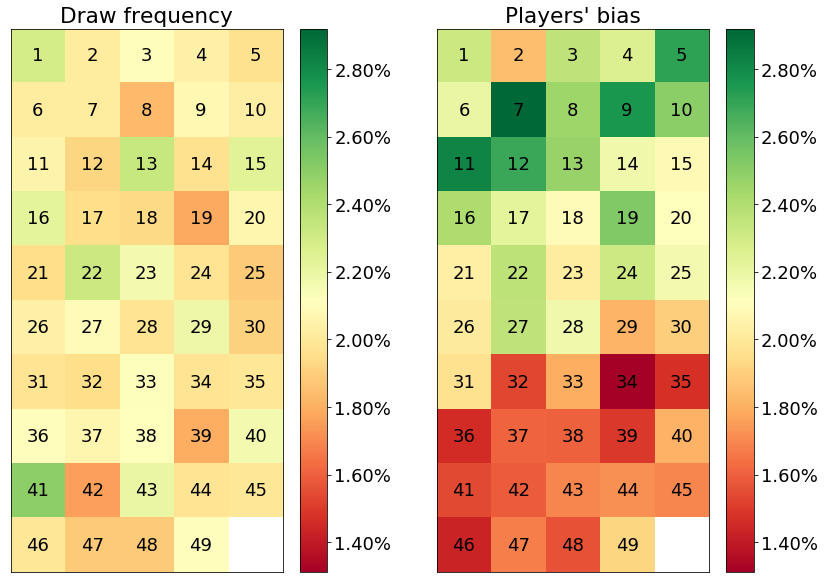

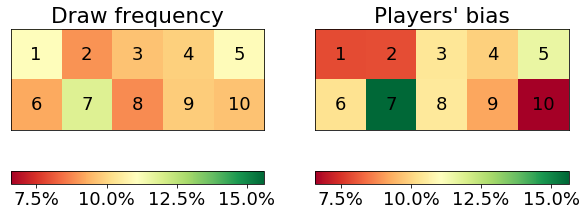

In [8]:
from matplotlib.colors import Normalize
fig, axs = plt.subplots(1, 2, figsize=(14, 10))
norm = Normalize(min(normal_frequency.min(), normal_probs.min()), max(normal_frequency.max(), normal_probs.max()))
plot_probs_in_grid(normal_frequency, ax=axs[0], title='Draw frequency', norm=norm)
plot_probs_in_grid(normal_probs, ax=axs[1], title='Players\' bias', norm=norm)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
norm = Normalize(min(lucky_frequency.min(), lucky_probs.min()), max(lucky_frequency.max(), lucky_probs.max()))
plot_probs_in_grid(lucky_frequency, ax=axs[0], title='Draw frequency', norm=norm)
plot_probs_in_grid(lucky_probs, ax=axs[1], title='Players\' bias', norm=norm)
plt.show()

In [9]:
expected_players = pd.DataFrame({
    'players': model.predict(inputs_values)[0].flatten(),
    'date': data['date'],
    'jackpot': data['jackpot'],
    'weekday': data['date'].dt.weekday.map({0: 'Monday', 2: 'Wednesday', 5: 'Saturday'})
})

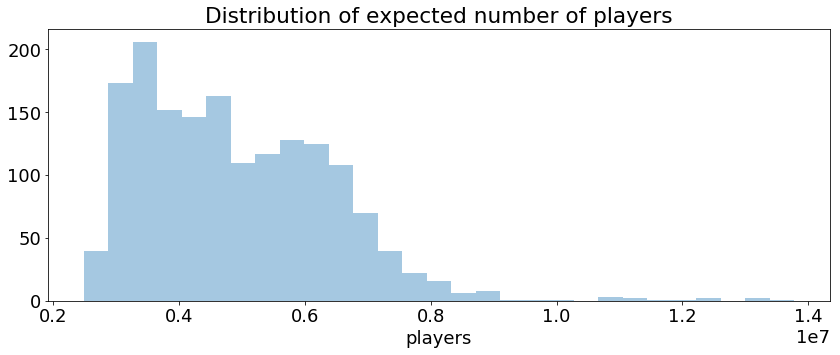

In [10]:
import seaborn as sns

plt.figure(figsize=(14, 5))
sns.distplot(expected_players['players'], norm_hist=False, kde=False)
plt.title('Distribution of expected number of players')
plt.show()

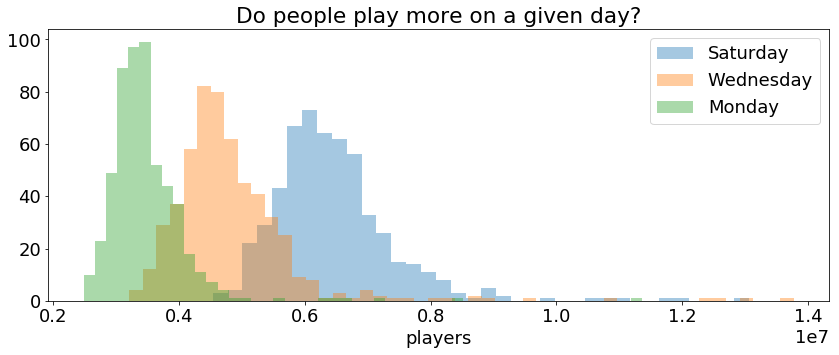

In [11]:
plt.figure(figsize=(14, 5))
for wd in expected_players['weekday'].unique():
    df = expected_players[expected_players['weekday'] == wd]
    sns.distplot(df['players'], label=wd, norm_hist=False, kde=False)
plt.legend()
plt.title('Do people play more on a given day?')
plt.show()

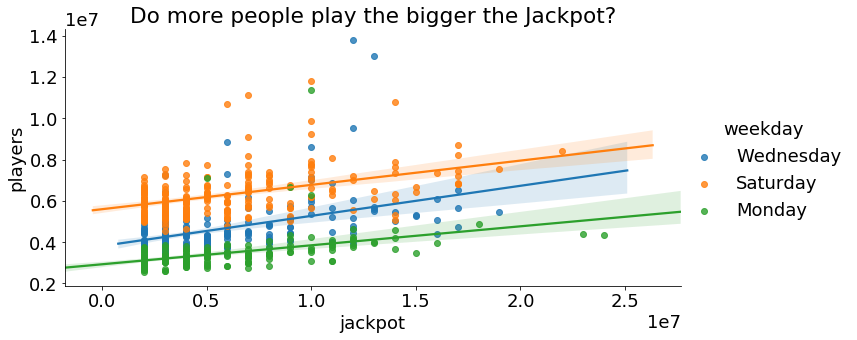

In [12]:
sns.lmplot(
    'jackpot',
    'players',
    hue='weekday',
    data=expected_players[expected_players['jackpot'] != 0],
    aspect=2
)
plt.title('Do more people play the bigger the Jackpot?')
plt.show()